# Charged Particle in an Electromagnetic Field Using SympNet


In [16]:
'''
Loading Modules
'''
import numpy as np
import learner as ln

from os.path import join

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
'''
Loading Data
'''
def load_data(dataset, base_path = '../data_lorentz/'):
    if dataset in ('train', 'test'):
        data = np.loadtxt(join(base_path, dataset + '.txt'), delimiter = ' ')
        print(f'Successfully Loaded {dataset} data...')
    else:
        raise Exception("Input must be either 'train' or 'test'")
        
    return data


In [12]:
data_train = load_data('train')

Successfully Loaded train data...


In [13]:
data_test = load_data('test')

Successfully Loaded test data...


In [6]:
v, x = data_train[:, :2], data_train[:, 2:]

In [9]:
x.shape
data_test.shape

(300, 4)

In [8]:
data_test[0].ndim

1

(-1.8517079409685466,
 1.856680207665636,
 -1.8565415996878276,
 1.851846548946355)

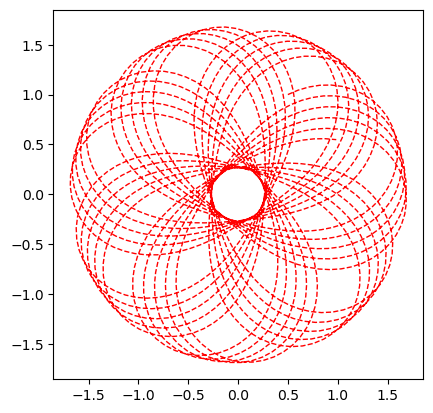

In [14]:
plt.plot(x[:,0], x[:, 1], 'r--', linewidth = 1)
plt.axis('square')

In [ ]:
'''
Prepare Data for the SympNet ######
'''
class LorentzData(ln.Data):
    '''
    Data for learning the Lorentz system with the Hamiltonian
    H(v,x) = mv^2/2 + q phi(x)
    
    -----
    with m = 1, q = 1, phi(x) = 1 / (100 * norm(x))
    H(v,x) = v^2/2 + 1 / (100 * norm(x))
    Then 
    dH = v + 
    '''
    def __init__(self, x0, h, train_num, test_num, add_h):
        super(LorentzData, self).__init__()
        self.dH = 

In [22]:
'''
Prepare Data ######
'''
DIM = 4
X0 = np.array([1,0.5,0.5,1])
h = 0.1
train_num = 1500
test_num = 300


In [17]:
class LData(ln.Data):
    '''
    Alternative way to construct Data for Learning the Lorentz system
    by providing the exact train and test data
    '''
    def __init__(self, train_data, test_data, device = 'cpu'):
        super(LData,self).__init__()
        x_train, y_train = train_data
        x_test, y_test = test_data
        
        self.X_train = x_train
        self.y_train = y_train
        self.X_test = x_test
        self.y_test = y_test
        
        self.__device = device
        self.__dtype = 'float'

In [18]:
'''
Prepare Data by directly passing in the loaded data
'''
Ldata = LData([data_train[:-1], data_train[1:]],\
             [data_test[:-1], data_test[1:]])

In [37]:
'''
Symplectic-Neural-Networks SympNet - Lorentz
'''
import learner as ln
from learner.integrator.hamiltonian import SV


def plot_trajectory(data, net, steps, h = 0.1): #######
    '''
    Plot the Ground Truth (Spatial) Trajectory against the Predicted
    
    input:
        - data      : [data_train, data_test] Ground Truth trajectory data to be plotted
        - net       : Network to predict flow/trajectory based on first point of data_test
        - steps     : Number of steps to predict in trajectory
        - h         : Default uniform grid size 0.1
    '''
    data_train, data_test = data
    
    flow_true = data_test
    if isinstance(net, ln.nn.HNN):
        flow_pred = net.predict(data_test[0][:-1], h, steps, keepinitx=True, returnnp=True)
    else:
        flow_pred = net.predict(data_test[0], steps, keepinitx=True, returnnp=True)
    
    # Plot spatial Locations for data (v1, v2, x1, x2)
    plt.plot(flow_true[:, 2], flow_true[:, 3], 'b-', label = 'Ground Truth', zorder = 0)
    plt.plot(flow_pred[:, 2], flow_pred[:, 3], 'r-', label = 'Predicted Flow', zorder = 1)
    plt.plot(data_train[:, 2], data_train[:, 3], 'b.', label = 'Learnt Data', zorder = 2)
    plt.xlabel(f'$x_1$')
    plt.ylabel(f'$x_2$')
    plt.legend()
    plt.axis('square')
    
def plot(data, net, steps, text = 'Positional Predictions'):
    if isinstance(net, ln.nn.HNN):
        #flow_true = data.solver.flow(data.X_test_np[0][:-1], data.h, steps)
        flow_true = data.y_test_np[:-1]
        flow_pred = net.predict(data.X_test[0][:-1], data.h, steps, keepinitx=True, returnnp=True).numpy()
    else:
        #flow_true = data.solver.flow(data.X_test_np[0], data.h, steps)
        flow_true = data.y_test_np
        flow_pred = net.predict(data.X_test[0], steps, keepinitx=True, returnnp=True)
    
    plt.figure(figsize=[6.4 * 1, 5.5 * 2])
    
    plt.subplot(211)
    plt.plot(flow_true[:, 2], flow_true[:, 3], 'b-', label='Ground truth', zorder=0, linewidth = 3)
    plt.plot(flow_pred[:, 2], flow_pred[:, 3], 'r-', label='Predicted flow', zorder=1, linewidth = 2)
    plt.plot(data.X_train_np[:, 2], data.X_train_np[:, 3], 'k.', label='Learnt data', zorder=2, linewidth = 2)
    plt.xlabel(f'$x_1$')
    plt.ylabel(f'$x_2$')
    plt.title(text)
    plt.legend()
    plt.axis('equal')
    plt.subplots_adjust(right=1.2)
    
    plt.subplot(212)
    print('flow_true', flow_true.shape)
    print('flow_pred', flow_pred.shape)
    # Calculate the MSE w.r.t. time t for the predicted results (for the test predictions)
    def MSE(y_pred, y_true):
        diff = y_pred - y_true
        if 1 == y_pred.ndim:
            return np.mean(diff ** 2)
        elif 2 == y_pred.ndim:
            return np.mean(np.sum(diff ** 2, axis = -1))
    
    num_test = len(flow_true)
    MSE_losses = [MSE(flow_pred[:i+1], flow_true[:i+1]) for i in range(num_test)]
    plt.plot(np.arange(num_test), MSE_losses)
    plt.title('Predicted MSE Loss v.s. Time')
    
    np.save('SympNetloss',np.array(MSE_losses))
    return MSE_losses

def init_network(data_dim, net_type, num_layers, width):
    '''
    Initialize the Symplectic Network: LA, G, or HNN
    
    input
        - data_dim  : 
        - net_type  : LA, G or HNN
        - num_layers: 
        - width     : Number of sublayers for LA;
                      Network Width for G and HNN
        *- activation: 'sigmoid' for LA and G
                      'tanh' for HNN
                      
    output 
        - net       :
        - criterion : None for HNN; 'MSE' otherwise
    '''
    criterion = 'MSE'
    if 'LA' == net_type:
        net = ln.nn.LASympNet(data_dim, num_layers, width, 'sigmoid')
    elif 'G' == net_type:
        net = ln.nn.GSympNet(data_dim, num_layers, width, 'sigmoid')
    elif 'HNN' == net_type:
        net = ln.nn.HNN(data_dim, num_layers, width, 'tanh')
        criterion = None
    return net, criterion


    
    

In [23]:
'''
Initialize the SympNet and Start training 
'''
net_type = 'LA'
num_iter = 3000
num_l = 10
w = 10

net, criterion = init_network(DIM, net_type, num_layers = num_l, width = w)

args = {
    'data': Ldata,
    'net' : net,
    'criterion': criterion,
    'optimizer': 'adam',
    'lr': 1e-3,
    'iterations': num_iter,
    'batch_size': None,
    'print_every': 1000,
    'save': True,
    'callback': None,
    'dtype' : 'float',
    'device' : 'cpu'
}

# Train the model?
ln.Brain.Init(**args)
ln.Brain.Run()
# Only Restore when 'save' = True
ln.Brain.Restore()
ln.Brain.Output()

Training...
0        Train loss: 0.016884615644812584     Test loss: 0.01693812571465969      
1000     Train loss: 0.0009611098794266582    Test loss: 0.0009611440473236144    
2000     Train loss: 0.0009211738943122327    Test loss: 0.0009233286837115884    
3000     Train loss: 0.0008999197743833065    Test loss: 0.0009034969843924046    
3019     Train loss: 0.0008999197743833065    Test loss: 0.0009034969843924046    
Done!
'run' took 76.93312788009644 s
Best model at iteration 3000:
Train loss: 0.0008999197743833065 Test loss: 0.0009034969843924046


flow_true (299, 4)
flow_pred (299, 4)


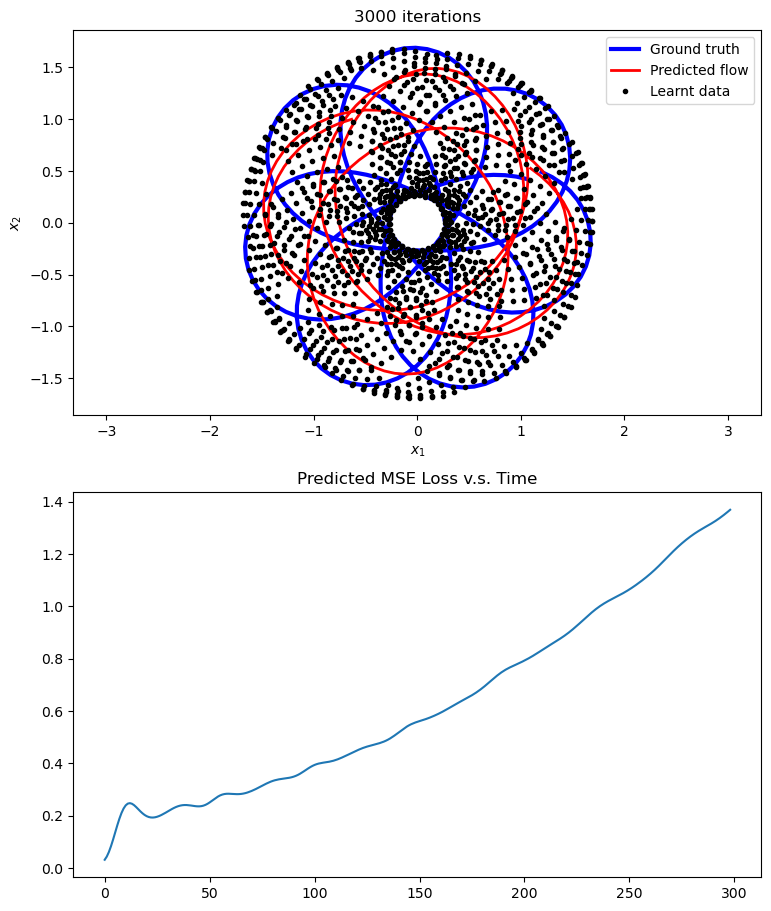

In [38]:
losses = plot(Ldata, ln.Brain.Best_model(), 298, text = f'{num_iter} iterations')

torch.Size([4])